# Playground Bachelor Thesis
## Lenet on MNIST

In [1]:
import time # for "stop watch"
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune

from Lenet import Lenet

In [2]:
def train_net(net, learning_rate=1.2e-4, epochs=3):
    loss_history = []
    val_acc_history = []
    
    # the function parameters() is implemented in nn.Module
    params = list(net.parameters())
    
    cross_entropy = nn.CrossEntropyLoss() # instantiate loss
    opt = optim.Adam(params, lr=learning_rate) # instantiate optimizer
    
    for i in range(0, epochs):
        tic = time.time()
        for j,(inputs, labels) in enumerate(training_loader):
            # zero the parameter gradients
            opt.zero_grad()
            
            # regularization loss
            reg_loss = 0
            for param in net.parameters():
                reg_loss += torch.sum(torch.abs(param))
            
            # forward pass
            outputs = net(inputs)
        
            # training loss
            train_loss = cross_entropy(outputs, labels)
            
            # calculate total loss
            loss = train_loss + 0.00005*reg_loss
            
            # backward pass
            loss.backward()
            opt.step()
            
            if (j+1)%100==0:
                loss_history.append(loss.item())
            #if (j+1)%450==0:
                #print(f"epoch: {(i+1):2} batch: {(j+1):4} loss: {(loss_history[-1]):3.4}")
        
        val_acc_history.append(compute_validation_accuracy(net))
        toc = time.time()
        print(f"epoch: {(i+1):2} val-acc: {(val_acc_history[-1]):1.4} (took {(toc-tic):.4}s)")
    return net, val_acc_history, loss_history

In [3]:
def compute_test_accuracy(net):
    net.train(False) # set model to evaluation mode (important for batchnorm/dropout)
    
    test_output, test_labels = [(net(data), target) for data, target in test_loader][0]
    predicted_class = test_output.max(dim = 1)[1] 
    
    return (predicted_class == test_labels).float().mean().item()

In [4]:
def compute_validation_accuracy(net):
    net.train(False) # set model to evaluation mode (important for batchnorm/dropout)
    
    validation_output, validation_labels = [(net(data), target) for data, target in validation_loader][0]
    predicted_class = validation_output.max(dim = 1)[1] 
    
    return (predicted_class == validation_labels).float().mean().item()

## Experiment setup

In [5]:
# experiment parameters
net_count = 3
epoch_count = 5
learning_rate = 1.2e-3
prune_rate = 0.2
prune_count = 3

In [6]:
# start clock for experiment duration
experiment_start = time.time()

In [7]:
# load dataset
tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

training_data = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=tr)
training_data, validation_data = torch.utils.data.random_split(training_data, [55000, 5000])
training_loader = torch.utils.data.DataLoader(training_data, batch_size=60,
                                          shuffle=True, num_workers=1)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=len(validation_data),
                                          shuffle=True, num_workers=1)

test_data = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=tr)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data),
                                         shuffle=True, num_workers=1)

len(training_data), len(training_loader), len(validation_data), len(validation_loader), len(test_data), len(test_loader)

(55000, 917, 5000, 1, 10000, 1)

In [8]:
# initialize neural networks
nets = [None] * net_count

for n in range(net_count):
    nets[n] = Lenet()

print(nets[0])

Lenet(
  (layer1): Linear(in_features=784, out_features=300, bias=True)
  (layer2): Linear(in_features=300, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=10, bias=True)
)


## Train and evaluate original networks (i.e. without pruning)

In [9]:
# train neural networks
val_acc_histories = [float] * net_count
loss_histories = [float] * net_count

for n in range(net_count):
    print(f"Train network #{n}")
    nets[n], val_acc_histories[n], loss_histories[n] = train_net(nets[n], learning_rate, epoch_count)

Train network #0
epoch:  1 val-acc: 0.9612 (took 11.43s)
epoch:  2 val-acc: 0.9608 (took 11.01s)
epoch:  3 val-acc: 0.9622 (took 10.87s)
epoch:  4 val-acc: 0.9666 (took 10.9s)
epoch:  5 val-acc: 0.9664 (took 10.87s)
Train network #1
epoch:  1 val-acc: 0.967 (took 10.9s)
epoch:  2 val-acc: 0.9648 (took 10.91s)
epoch:  3 val-acc: 0.9682 (took 11.17s)
epoch:  4 val-acc: 0.9648 (took 10.89s)
epoch:  5 val-acc: 0.965 (took 11.16s)
Train network #2
epoch:  1 val-acc: 0.9496 (took 11.75s)
epoch:  2 val-acc: 0.9616 (took 10.95s)
epoch:  3 val-acc: 0.9628 (took 10.91s)
epoch:  4 val-acc: 0.9722 (took 11.04s)
epoch:  5 val-acc: 0.969 (took 11.22s)


In [10]:
# calculate accuracies on test-set
accs = [float] * net_count

for n in range(net_count):
    accs[n] = compute_test_accuracy(nets[n])
    print(f"Accuracy net #{n}: {(accs[n]):1.4}")

Accuracy net #0: 0.9663
Accuracy net #1: 0.966
Accuracy net #2: 0.9711


(0, 0.9635293610394001)

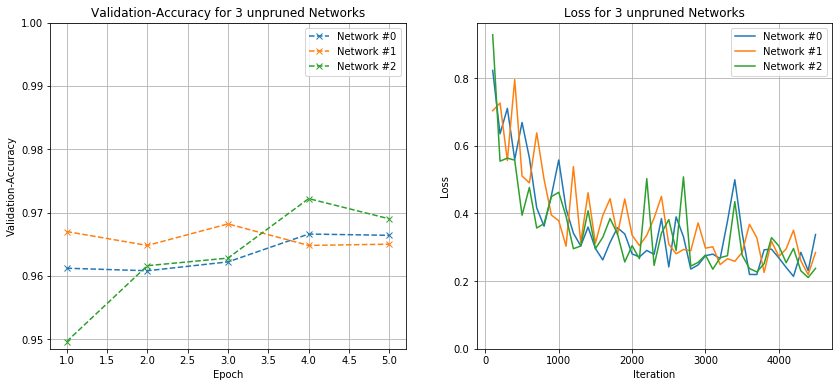

In [11]:
# plot validation-accuracies and loss
fig_results = plt.figure(None, (14, 6))
ax_val_acc, ax_loss = fig_results.subplots(1,2, sharex=False)

val_acc_xs = np.linspace(start=1, stop=epoch_count, num=epoch_count)
loss_xs = np.linspace(start=100, stop=len(loss_histories[0])*100, num=len(loss_histories[0]))

for n in range(net_count):
    ax_val_acc.plot(val_acc_xs, val_acc_histories[n], 'x--', label=f"Network #{n}");
    ax_loss.plot(loss_xs, loss_histories[n], '-', label=f"Network #{n}");

ax_val_acc.set_title(f"Validation-Accuracy for {net_count} unpruned Networks")
ax_val_acc.set_ylabel("Validation-Accuracy")
ax_val_acc.set_xlabel("Epoch")

ax_loss.set_title(f"Loss for {net_count} unpruned Networks")
ax_loss.set_ylabel("Loss")
ax_loss.set_xlabel("Iteration")

ax_val_acc.legend()
ax_loss.legend()

ax_val_acc.grid('major')
ax_loss.grid('major')
ax_val_acc.set_ylim(top=1)
ax_loss.set_ylim(bottom=0)

In [12]:
# calculate means and error bars for validation-accuracy and loss
val_acc_mean = np.mean(val_acc_histories, axis=0)
val_acc_neg_yerr = val_acc_mean - np.min(val_acc_histories, axis=0)
val_acc_pos_yerr = np.max(val_acc_histories, axis=0) - val_acc_mean

loss_mean = np.mean(loss_histories, axis=0)
loss_neg_yerr = loss_mean - np.min(loss_histories, axis=0)
loss_pos_yerr = np.max(loss_histories, axis=0) - loss_mean

(0, 0.9635293610394001)

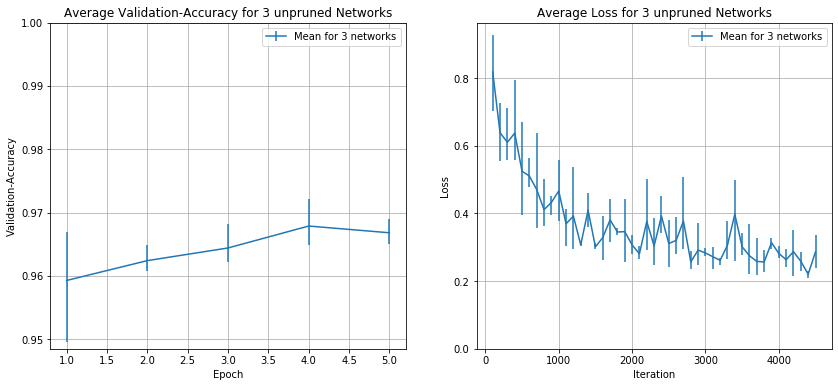

In [13]:
# plot means and error bars for validation-accuracy and loss
fig_average = plt.figure(None, (14, 6))
ax_val_acc_av, ax_loss_av = fig_average.subplots(1,2, sharex=False)

ax_val_acc_av.errorbar(x=val_acc_xs, y=val_acc_mean, yerr=[val_acc_neg_yerr, val_acc_pos_yerr], label=f"Mean for {net_count} networks")
ax_loss_av.errorbar(x=loss_xs, y=loss_mean, yerr=[loss_neg_yerr, loss_pos_yerr], label=f"Mean for {net_count} networks")

ax_val_acc_av.set_title(f"Average Validation-Accuracy for {net_count} unpruned Networks")
ax_val_acc_av.set_ylabel("Validation-Accuracy")
ax_val_acc_av.set_xlabel("Epoch")

ax_loss_av.set_title(f"Average Loss for {net_count} unpruned Networks")
ax_loss_av.set_ylabel("Loss")
ax_loss_av.set_xlabel("Iteration")

ax_val_acc_av.legend()
ax_loss_av.legend()

ax_val_acc_av.grid('major')
ax_loss_av.grid('major')
ax_val_acc_av.set_ylim(top=1)
ax_loss_av.set_ylim(bottom=0)

## Train and evaluate pruned networks

In [14]:
pruned_val_acc_histories = [[float] * prune_count for _ in range(net_count)]
pruned_loss_histories = [[float] * prune_count for _ in range(net_count)]
pruned_accs = [[float] * prune_count for _ in range(net_count)]
sparsity_history = [float] * prune_count

print(f"Prune networks with rate {prune_rate}.")
for n in range(net_count):
    for p in range(prune_count):
        print(f"Prune network #{n} in round {p+1}", end="")
        nets[n].prune_net(prune_rate)
        
        if n==0:
            sparsity_history[p] = nets[0].sparsity_report()[0]
        print(f" (sparsity {sparsity_history[p]:.6}).", end="")
        
        print(" Train network.")
        nets[n], pruned_val_acc_histories[n][p], pruned_loss_histories[n][p] = train_net(nets[n], learning_rate, epoch_count)
        
        pruned_accs[n][p] = compute_test_accuracy(nets[n])
        print(f"Test-accuracy: {(pruned_accs[n][p]):1.4}")
    print()

Prune networks with rate 0.2.
Prune network #0 in round 1 (sparsity 0.8004). Train network.
epoch:  1 val-acc: 0.9606 (took 11.23s)
epoch:  2 val-acc: 0.9686 (took 11.0s)
epoch:  3 val-acc: 0.9688 (took 10.98s)
epoch:  4 val-acc: 0.9718 (took 11.0s)
epoch:  5 val-acc: 0.9696 (took 10.92s)
Test-accuracy: 0.972
Prune network #0 in round 2 (sparsity 0.6406). Train network.
epoch:  1 val-acc: 0.9732 (took 10.96s)
epoch:  2 val-acc: 0.9718 (took 10.99s)
epoch:  3 val-acc: 0.9764 (took 11.01s)
epoch:  4 val-acc: 0.9754 (took 10.98s)
epoch:  5 val-acc: 0.969 (took 10.99s)
Test-accuracy: 0.9718
Prune network #0 in round 3 (sparsity 0.5128). Train network.
epoch:  1 val-acc: 0.9722 (took 10.94s)
epoch:  2 val-acc: 0.9768 (took 10.92s)
epoch:  3 val-acc: 0.9704 (took 10.91s)
epoch:  4 val-acc: 0.973 (took 10.92s)
epoch:  5 val-acc: 0.9742 (took 10.93s)
Test-accuracy: 0.9728

Prune network #1 in round 1 (sparsity 0.8004). Train network.
epoch:  1 val-acc: 0.9608 (took 10.87s)
epoch:  2 val-acc: 0

In [15]:
# calculate means and error bars for validation-accuracy and loss
pruned_val_acc_mean = np.mean(pruned_val_acc_histories, axis=0)
pruned_val_acc_neg_yerr = pruned_val_acc_mean - np.min(pruned_val_acc_histories, axis=0)
pruned_val_acc_pos_yerr = np.max(pruned_val_acc_histories, axis=0) - pruned_val_acc_mean

pruned_loss_mean = np.mean(pruned_loss_histories, axis=0)
pruned_loss_neg_yerr = pruned_loss_mean - np.min(pruned_loss_histories, axis=0)
pruned_loss_pos_yerr = np.max(pruned_loss_histories, axis=0) - pruned_loss_mean

(0, 0.9676317378878594)

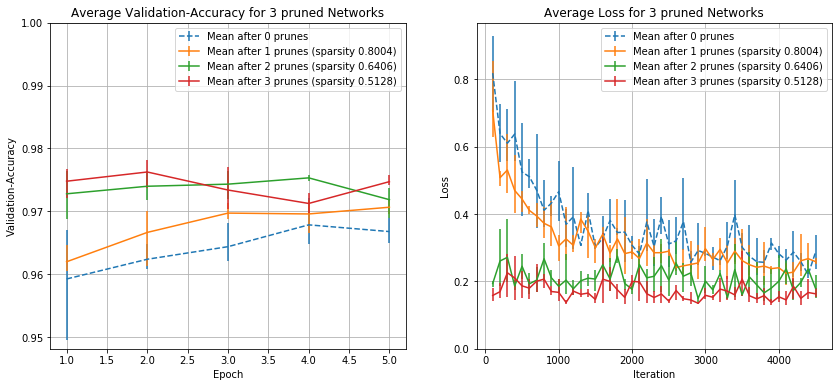

In [16]:
# plot means and error bars for validation-accuracy and loss
fig_average = plt.figure(None, (14, 6))
ax_pruned_val_acc_av, ax_pruned_loss_av = fig_average.subplots(1,2, sharex=False)

# plot baseline, i.e. unpruned results
ax_pruned_val_acc_av.errorbar(x=val_acc_xs, y=val_acc_mean, yerr=[val_acc_neg_yerr, val_acc_pos_yerr], label="Mean after 0 prunes", ls='--')
ax_pruned_loss_av.errorbar(x=loss_xs, y=loss_mean, yerr=[loss_neg_yerr, loss_pos_yerr], label="Mean after 0 prunes", ls='--')

# plot pruned results
for p in range(prune_count):
    ax_pruned_val_acc_av.errorbar(x=val_acc_xs, y=pruned_val_acc_mean[p], yerr=[pruned_val_acc_neg_yerr[p], pruned_val_acc_pos_yerr[p]], label=f"Mean after {p+1} prunes (sparsity {sparsity_history[p]:.4})")
    ax_pruned_loss_av.errorbar(x=loss_xs, y=pruned_loss_mean[p], yerr=[pruned_loss_neg_yerr[p], pruned_loss_pos_yerr[p]], label=f"Mean after {p+1} prunes (sparsity {sparsity_history[p]:.4})")

ax_pruned_val_acc_av.set_title(f"Average Validation-Accuracy for {net_count} pruned Networks")
ax_pruned_val_acc_av.set_ylabel("Validation-Accuracy")
ax_pruned_val_acc_av.set_xlabel("Epoch")

ax_pruned_loss_av.set_title(f"Average Loss for {net_count} pruned Networks")
ax_pruned_loss_av.set_ylabel("Loss")
ax_pruned_loss_av.set_xlabel("Iteration")

ax_pruned_val_acc_av.legend()
ax_pruned_loss_av.legend()

ax_pruned_val_acc_av.grid('major')
ax_pruned_loss_av.grid('major')
ax_pruned_val_acc_av.set_ylim(top=1)
ax_pruned_loss_av.set_ylim(bottom=0)

In [17]:
# calculate accuracies on test-set
pruned_accs = [float] * net_count

for n in range(net_count):
    pruned_accs[n] = compute_test_accuracy(nets[n])
    print(f"Accuracy net #{n}: {(pruned_accs[n]):1.4} (changed by {(pruned_accs[n]-accs[n]):1.4})")

Accuracy net #0: 0.9728 (changed by 0.0065)
Accuracy net #1: 0.9774 (changed by 0.0114)
Accuracy net #2: 0.9749 (changed by 0.0038)


In [18]:
nets[0].sparsity_report()

array([0.5128, 0.512 , 0.512 , 0.729 ])

In [19]:
# stop clock for experiment duration
experiment_stop = time.time()
minutes, seconds = divmod((experiment_stop-experiment_start), 60)
print(f"Experiment duration: {round(minutes)}:{round(seconds)}min")

Experiment duration: 11:27min
